In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Enhancing_EHRs_with_GenAI')

In [ ]:
import pandas as pd

ehr_file = 'data/raw/cancer_diagnosis_data.csv'
df = pd.read_csv(ehr_file)

print("=== EHR Dataset Study ===")
print(f"Total Rows: {len(df):,}")
print("\nColumns:", df.columns.tolist())


print("\nFirst 5 Rows (Table):")
df_head = df.head()
display(df_head.style.set_properties(**{'text-align': 'left'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'left')]}]
))


print("\nMissing Values (Table):")
df_missing = df.isnull().sum().to_frame(name='Missing Count')
display(df_missing.style.set_properties(**{'text-align': 'left'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'left')]}]
))

=== EHR Dataset Study ===
Total Rows: 20,000

Columns: ['Patient_ID', 'Age', 'Gender', 'Tumor_Size(cm)', 'Tumor_Type', 'Biopsy_Result', 'Treatment', 'Response_to_Treatment', 'Survival_Status']

First 5 Rows (Table):


,Patient_ID,Age,Gender,Tumor_Size(cm),Tumor_Type,Biopsy_Result,Treatment,Response_to_Treatment,Survival_Status
0,c044501a-43ca-4a0c-8b8b-991439ba1b6a,52,Female,5.080000,Benign,Positive,Surgery,No Response,Survived
1,b8900c4c-1232-4084-9432-5d02eba74d20,32,Female,0.800000,Benign,Negative,Surgery,Complete Response,Survived
2,3004e2bc-8037-49cb-a542-d5612b73beab,70,Female,9.560000,Benign,Positive,Radiation Therapy,Complete Response,Deceased
3,1df86af7-6745-4dea-b127-cbc9915079fc,21,Female,3.070000,Malignant,Negative,Surgery,Partial Response,Survived
4,128e00c3-72e3-4031-a7f4-1165d7199cce,62,Male,7.170000,Malignant,Positive,Radiation Therapy,Complete Response,Deceased



Missing Values (Table):


,Missing Count
Patient_ID,0
Age,0
Gender,0
Tumor_Size(cm),0
Tumor_Type,0
Biopsy_Result,0
Treatment,0
Response_to_Treatment,0
Survival_Status,0


=== Sample Images from data/raw/images/ ===


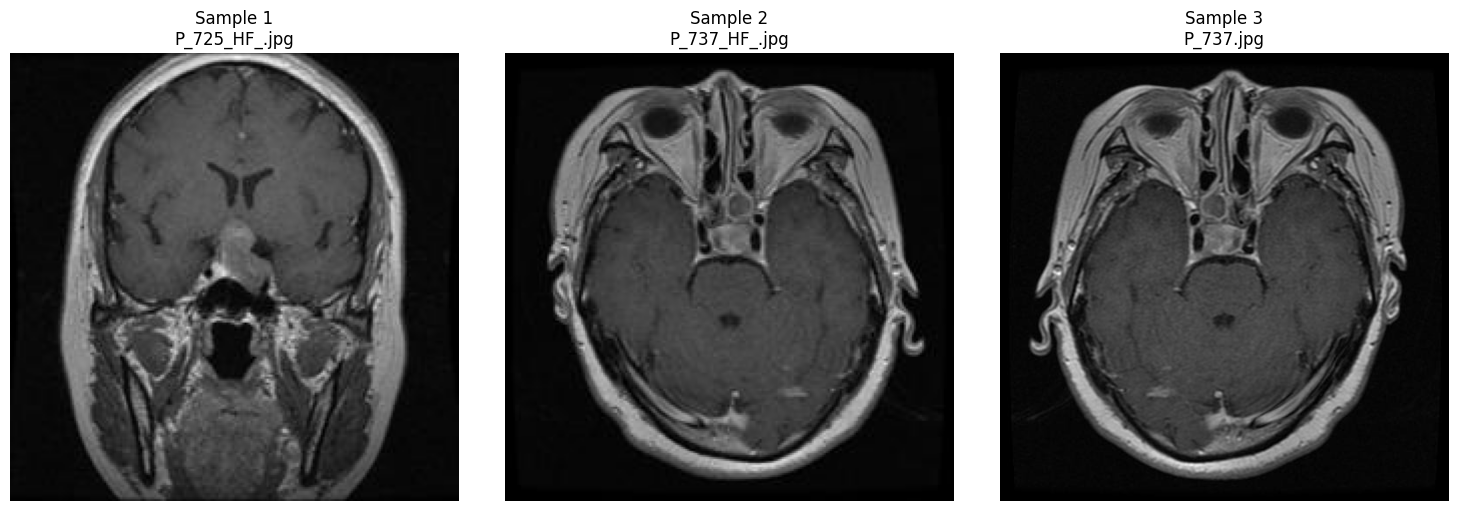


Total Images in data/raw/images/: 21672


In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

raw_dir = 'data/raw/images/'  
print("=== Sample Images from data/raw/images/ ===")


sample_images = [f for f in os.listdir(raw_dir) if f.lower().endswith(('.jpeg', '.jpg', '.png'))][:3]  # First 3 images

plt.figure(figsize=(15, 5))  
for idx, img_file in enumerate(sample_images):
    img_path = os.path.join(raw_dir, img_file)
    if os.path.exists(img_path):
        img = Image.open(img_path)
        plt.subplot(1, 3, idx + 1)  
        plt.imshow(img)
        plt.title(f'Sample {idx + 1}\n{img_file}')
        plt.axis('off')
plt.tight_layout()  
plt.show()
print(f"\nTotal Images in {raw_dir}: {len([f for f in os.listdir(raw_dir) if f.lower().endswith(('.jpeg', '.jpg', '.png'))])}")

In [ ]:
import os
import shutil

src_dirs = [
    'data/raw/brain_images/Tumor/pituitary_tumor',
    'data/raw/brain_images/Tumor/meningioma_tumor',
    'data/raw/brain_images/Tumor/glioma_tumor',
    'data/raw/brain_images/Normal'
]
dst = 'data/raw/images'
os.makedirs(dst, exist_ok=True)

image_count = 0
for src in src_dirs:
    if os.path.exists(src):
        for fn in os.listdir(src):
            if fn.lower().endswith(('.jpeg', '.jpg', '.png')):
                shutil.move(os.path.join(src, fn), os.path.join(dst, fn))
                image_count += 1
print(f"Moved {image_count} images to {dst}")

Moved 21672 images to data/raw/images


In [ ]:
!pip install pillow opencv-python numpy
import os
from PIL import Image
import numpy as np

SRC = 'data/raw/images/'
DST = 'data/images_processed/'
os.makedirs(DST, exist_ok=True)
TARGET = (256, 256)

processed_count = 0
for fn in os.listdir(SRC):
    path = os.path.join(SRC, fn)
    if fn.lower().endswith(('.jpeg', '.jpg', '.png')):
        img = Image.open(path).convert('L')  
        img = img.resize(TARGET)  
        outname = os.path.splitext(fn)[0] + '.png'
        img.save(os.path.join(DST, outname))
        processed_count += 1
print(f"Processed {processed_count} images to {DST}")

Processed 21672 images to data/images_processed/


In [ ]:
!pip install pandas
import pandas as pd
import os

SRC_CSV = 'data/raw/cancer_diagnosis_data.csv'
DST = 'data/ehr_notes_processed/'
os.makedirs(DST, exist_ok=True)

df = pd.read_csv(SRC_CSV)
for idx, row in df.head(21672).iterrows(): 
    note_text = f"Patient ID: {row['Patient_ID']}\nAge: {row['Age']}\nGender: {row['Gender']}\nTumor Size: {row['Tumor_Size(cm)']} cm\nTumor Type: {row['Tumor_Type']}\nBiopsy Result: {row['Biopsy_Result']}\nTreatment: {row['Treatment']}\nResponse to Treatment: {row['Response_to_Treatment']}\nSurvival Status: {row['Survival_Status']}"
    cleaned = "\n".join(line.strip() for line in note_text.split("\n") if line.strip())
    outfn = os.path.join(DST, f"patient_{row['Patient_ID']}.txt")
    with open(outfn, 'w', encoding='utf-8') as f:
        f.write(cleaned)
print(f"Created {min(21672, len(df))} TXT notes in {DST}")

Created 20000 TXT notes in data/ehr_notes_processed/


In [ ]:
import glob
import pandas as pd

images = sorted(glob.glob('data/images_processed/*.png'))
notes = sorted(glob.glob('data/ehr_notes_processed/*.txt'))

min_len = min(len(images), len(notes))  
rows = []
for i in range(min_len):
    pid = f"{i+1:04d}"
    rows.append({'file_id': pid, 'image_path': images[i], 'note_path': notes[i], 'diagnosis': '', 'icd10': ''})

pd.DataFrame(rows).to_csv('data/mapping.csv', index=False)
print(f"Created mapping.csv with {min_len} rows")

Created mapping.csv with 20000 rows


In [ ]:
import pandas as pd
import os

mapping_path = 'data/mapping.csv'
mapping = pd.read_csv(mapping_path)

lookup_data = [
    {'condition_keyword': 'malignant', 'icd10_code': 'C71.9', 'icd10_description': 'Malignant brain tumor'},
    {'condition_keyword': 'benign', 'icd10_code': 'D33.9', 'icd10_description': 'Benign brain tumor'},
    {'condition_keyword': 'no tumor', 'icd10_code': '', 'icd10_description': 'No tumor'}
]
pd.DataFrame(lookup_data).to_csv('data/icd_lookup.csv', index=False)

lookup = pd.read_csv('data/icd_lookup.csv')

def suggest_icd(note_path, image_path):
    if not os.path.exists(note_path):
        return 'UNKNOWN'
    with open(note_path, 'r', encoding='utf-8') as f:
        t = f.read().lower()

    if 'n_' in image_path.lower(): 
        '''print(f"Debug: Found N_ in {image_path}, setting icd10 to ''")'''
        return ''
    for _, r in lookup.iterrows():
        if r['condition_keyword'] in t:
            return r['icd10_code']
    return 'UNKNOWN'

def infer_diagnosis(note_path, image_path):
    if not os.path.exists(note_path):
        return 'UNKNOWN'
    with open(note_path, 'r', encoding='utf-8') as f:
        t = f.read().lower()
   
    if 'n_' in image_path.lower():  
        '''print(f"Debug: Found N_ in {image_path}, setting diagnosis to No Tumor")'''
        return 'No Tumor'
    if 'malignant' in t:
        return 'Malignant Brain Tumor'
    if 'benign' in t:
        return 'Benign Brain Tumor'
    return 'UNKNOWN'

for idx, row in mapping.iterrows():
    mapping.at[idx, 'icd10'] = suggest_icd(row['note_path'], row['image_path'])
    mapping.at[idx, 'diagnosis'] = infer_diagnosis(row['note_path'], row['image_path'])

mapping.to_csv(mapping_path, index=False)
print("Updated mapping.csv with prefix-prioritized diagnosis and icd10")

Updated mapping.csv with prefix-prioritized diagnosis and icd10


In [ ]:
import pandas as pd

mapping_path = 'data/mapping.csv'
mapping = pd.read_csv(mapping_path)

print("=== First 5 Rows of mapping.csv ===")
display(mapping.head().style.set_properties(**{'text-align': 'left'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'left')]}]
))

=== First 5 Rows of mapping.csv ===


,file_id,image_path,note_path,diagnosis,icd10
0,1,data/images_processed/G_1.png,data/ehr_notes_processed/patient_00049479-cadb-4dfe-a300-ddf12431e576.txt,Benign Brain Tumor,D33.9
1,2,data/images_processed/G_10.png,data/ehr_notes_processed/patient_0008d98d-1223-4bb5-b660-0457affb567a.txt,Malignant Brain Tumor,C71.9
2,3,data/images_processed/G_100.png,data/ehr_notes_processed/patient_000d4d65-4481-4fed-ade5-22c1c6e29840.txt,Benign Brain Tumor,D33.9
3,4,data/images_processed/G_100_BR_.png,data/ehr_notes_processed/patient_000ee478-ddc8-414c-8b24-21e85303024e.txt,Malignant Brain Tumor,C71.9
4,5,data/images_processed/G_100_DA_.png,data/ehr_notes_processed/patient_0018267e-abf0-43e2-8c33-112882ac098c.txt,Benign Brain Tumor,D33.9


In [ ]:
import pandas as pd
import os

mapping_path = 'data/mapping.csv'
mapping = pd.read_csv(mapping_path)

print("=== Spot-Check 5 Random Rows ===")
sample = mapping.sample(n=5, random_state=42)  # Random but reproducible
for idx, row in sample.iterrows():
    print(f"Row {idx}:")
    print(f"  Image: {row['image_path']}")
    print(f"  Note: {row['note_path']}")
    print(f"  Diagnosis: {row['diagnosis']}")
    print(f"  ICD-10: {row['icd10']}")
    print("---")

print("\n=== Integrity Check ===")
missing_paths = mapping[~mapping['image_path'].apply(os.path.exists) | ~mapping['note_path'].apply(os.path.exists)]
print(f"Missing image or note paths: {len(missing_paths)}")
unique_diags = mapping['diagnosis'].value_counts(dropna=False)
print(f"Unique Diagnoses:\n{unique_diags}")
unique_icds = mapping['icd10'].value_counts(dropna=False)
print(f"Unique ICD-10 Codes:\n{unique_icds}")
print(f"Rows with 'UNKNOWN' diagnosis: {(mapping['diagnosis'] == 'UNKNOWN').sum()}")
print(f"Rows with 'UNKNOWN' ICD-10: {(mapping['icd10'] == 'UNKNOWN').sum()}")

=== Spot-Check 5 Random Rows ===
Row 10650:
  Image: data/images_processed/M_65_DA_.png
  Note: data/ehr_notes_processed/patient_882aa78e-82e7-48a1-8e5e-88516b91ebea.txt
  Diagnosis: Benign Brain Tumor
  ICD-10: D33.9
---
Row 2041:
  Image: data/images_processed/G_363_DA_.png
  Note: data/ehr_notes_processed/patient_1908cbb4-fa89-4265-8830-e7c572e41b03.txt
  Diagnosis: Malignant Brain Tumor
  ICD-10: C71.9
---
Row 8668:
  Image: data/images_processed/M_404.png
  Note: data/ehr_notes_processed/patient_6e698f20-a355-4abb-8a16-7a79c6233651.txt
  Diagnosis: Benign Brain Tumor
  ICD-10: D33.9
---
Row 1114:
  Image: data/images_processed/G_243_VF_.png
  Note: data/ehr_notes_processed/patient_0de7336f-4e09-47ed-9202-d59e455e96e5.txt
  Diagnosis: Malignant Brain Tumor
  ICD-10: C71.9
---
Row 13902:
  Image: data/images_processed/N_255_SP_.png
  Note: data/ehr_notes_processed/patient_b136dd2d-8017-40bf-9fa6-a281da320914.txt
  Diagnosis: No Tumor
  ICD-10: nan
---

=== Integrity Check ===
Missin

In [ ]:
import pandas as pd
import os
import re


mapping_path = 'data/mapping.csv'
mapping = pd.read_csv(mapping_path)

print("=== Final Integrity Check ===")
missing_images = mapping[~mapping['image_path'].apply(os.path.exists)]
missing_notes = mapping[~mapping['note_path'].apply(os.path.exists)]
print(f"Missing images: {len(missing_images)}")
print(f"Missing notes: {len(missing_notes)}")


bad_icd = mapping[~mapping['icd10'].apply(lambda x: pd.isna(x) or bool(re.match(r'^[A-Z][0-9]{2}(?:\.[0-9A-Za-z]{1,4})?$', str(x))))]
print(f"Invalid ICD-10 codes: {len(bad_icd)}")

print(f"Total rows: {len(mapping)}")
print(f"Unique Diagnoses: {mapping['diagnosis'].value_counts().to_dict()}")
print(f"Unique ICD-10: {mapping['icd10'].value_counts(dropna=False).to_dict()}")

=== Final Integrity Check ===
Missing images: 0
Missing notes: 0
Invalid ICD-10 codes: 0
Total rows: 20000
Unique Diagnoses: {'Benign Brain Tumor': 8502, 'Malignant Brain Tumor': 8432, 'No Tumor': 3066}
Unique ICD-10: {'D33.9': 8502, 'C71.9': 8432, nan: 3066}
